Transfer Learning for Image Classification [Traffic Sign Recognition] using Torchvision, Pytorch and Python

In [1]:
!nvidia-smi

Tue Jun  9 17:16:49 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
import torch, torchvision

from pathlib import Path
import numpy as np
import cv2
import pandas as pd
from tqdm import tqdm
import PIL.Image as Image
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from glob import glob
import shutil
from collections import defaultdict

from torch import nn, optim

import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 16, 12

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

import pandas.util.testing as tm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

In [4]:
!wget https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip

--2020-06-09 17:17:16--  https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip
Resolving sid.erda.dk (sid.erda.dk)... 130.225.104.13
Connecting to sid.erda.dk (sid.erda.dk)|130.225.104.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276294756 (263M) [application/zip]
Saving to: ‘GTSRB_Final_Training_Images.zip’

GTSRB_Final_Trainin 100%[===================>] 263.50M  15.3MB/s    in 16s     

2020-06-09 17:17:33 (16.4 MB/s) - ‘GTSRB_Final_Training_Images.zip’ saved [276294756/276294756]



In [0]:
!unzip -qq GTSRB_Final_Training_Images.zip

In [6]:
train_folders = sorted(glob('GTSRB/Final_Training/Images/*'))
len(train_folders)

43

Exploration:

In [0]:
def load_image(img_path, resize=True):
  img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

  if resize:
    img = cv2.resize(img, (64, 64), interpolation = cv2.INTER_AREA)

  return img

def show_image(img_path):
  img = load_image(img_path)
  plt.imshow(img)
  plt.axis('off')

def show_sign_grid(image_paths):
  images = [load_image(img) for img in image_paths]
  images = torch.as_tensor(images)
  images = images.permute(0, 3, 1, 2)
  grid_img = torchvision.utils.make_grid(images, nrow=11)
  plt.figure(figsize=(24, 12))
  plt.imshow(grid_img.permute(1, 2, 0))
  plt.axis('off');

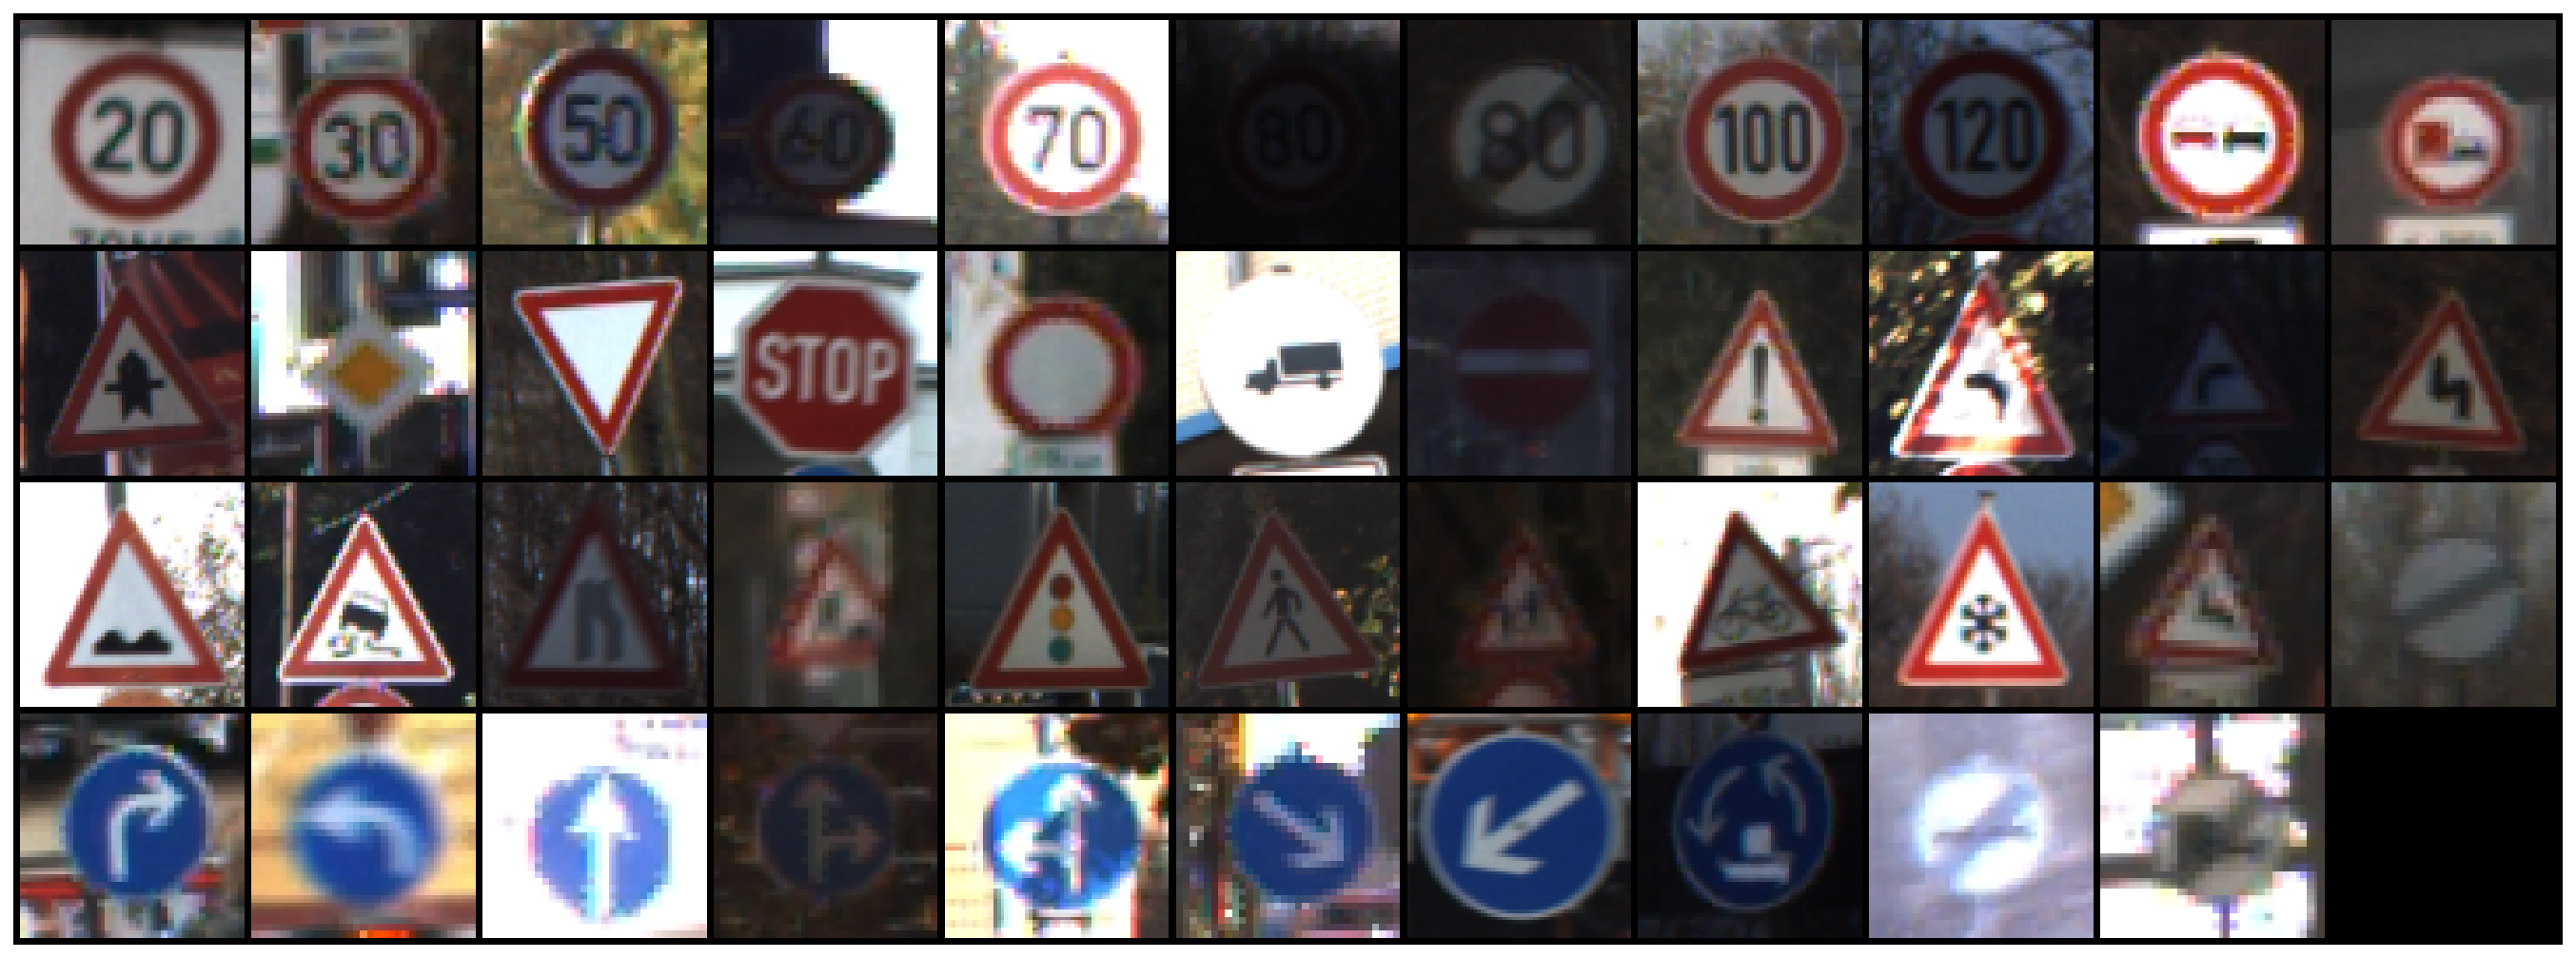

In [8]:

sample_images = [np.random.choice(glob(f'{tf}/*ppm')) for tf in train_folders]
show_sign_grid(sample_images)

Creating Classes:

In [0]:
class_names = ['Speed limit (20km/h)','Speed limit (30km/h)', 'Speed limit (50km/h)', 'Speed limit (60km/h)', 'Speed limit (70km/h)','Speed limit (80km/h)', 'End of speed limit (80km/h)', 'Speed limit (100km/h)', 
            'Speed limit (120km/h)', 'No passing', 'No passing veh over 3.5 tons', 'Right-of-way at intersection', 'Priority road', 'Yield', 'Stop', 'No vehicles', 
            'Veh > 3.5 tons prohibited', 'No entry', 'General caution', 'Dangerous curve left', 'Dangerous curve right', 'Double curve', 'Bumpy road', 'Slippery road', 
            'Road narrows on the right', 'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing', 'Bicycles crossing', 'Beware of ice/snow','Wild animals crossing', 
            'End speed + passing limits', 'Turn right ahead', 'Turn left ahead', 'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right', 
            'Keep left', 'Roundabout mandatory', 'End of no passing',  'End no passing veh > 3.5 tons' 
]

class_indices = [i for i in range(43)]

In [0]:
!rm -rf data

DATA_DIR = Path('data')

DATASETS = ['train', 'val', 'test']

for ds in DATASETS:
  for cls in class_names:
    (DATA_DIR / ds / cls).mkdir(parents=True, exist_ok=True)

Train, Test, validation Split

In [16]:
for i, cls_index in enumerate(class_indices):
  image_paths = np.array(glob(f'{train_folders[cls_index]}/*.ppm'))
  class_name = class_names[i]
  print(f'{class_name}: {len(image_paths)}')
  np.random.shuffle(image_paths)

  ds_split = np.split(
    image_paths, 
    indices_or_sections=[int(.8*len(image_paths)), int(.9*len(image_paths))]
  )

  dataset_data = zip(DATASETS, ds_split)

  for ds, images in dataset_data:
    for img_path in images:
      shutil.copy(img_path, f'{DATA_DIR}/{ds}/{class_name}/')

Speed limit (20km/h): 210
Speed limit (30km/h): 2220
Speed limit (50km/h): 2250
Speed limit (60km/h): 1410
Speed limit (70km/h): 1980
Speed limit (80km/h): 1860
End of speed limit (80km/h): 420
Speed limit (100km/h): 1440
Speed limit (120km/h): 1410
No passing: 1470
No passing veh over 3.5 tons: 2010
Right-of-way at intersection: 1320
Priority road: 2100
Yield: 2160
Stop: 780
No vehicles: 630
Veh > 3.5 tons prohibited: 420
No entry: 1110
General caution: 1200
Dangerous curve left: 210
Dangerous curve right: 360
Double curve: 330
Bumpy road: 390
Slippery road: 510
Road narrows on the right: 270
Road work: 1500
Traffic signals: 600
Pedestrians: 240
Children crossing: 540
Bicycles crossing: 270
Beware of ice/snow: 450
Wild animals crossing: 780
End speed + passing limits: 240
Turn right ahead: 689
Turn left ahead: 420
Ahead only: 1200
Go straight or right: 390
Go straight or left: 210
Keep right: 2070
Keep left: 300
Roundabout mandatory: 360
End of no passing: 240
End no passing veh > 3.5

Data Augumentation:

In [0]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

transforms = {'train': T.Compose([
  T.RandomResizedCrop(size=256),
  T.RandomRotation(degrees=15),
  T.RandomHorizontalFlip(),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'val': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]), 'test': T.Compose([
  T.Resize(size=256),
  T.CenterCrop(size=224),
  T.ToTensor(),
  T.Normalize(mean_nums, std_nums)
]),
}

Creating pytorch DataSet:

In [0]:
image_datasets = {
  d: ImageFolder(f'{DATA_DIR}/{d}', transforms[d]) for d in DATASETS
}

data_loaders = {
  d: DataLoader(image_datasets[d], batch_size=4, shuffle=True, num_workers=4) 
  for d in DATASETS
}

In [19]:
dataset_sizes = {d: len(image_datasets[d]) for d in DATASETS}
class_names = image_datasets['train'].classes

dataset_sizes

{'test': 3921, 'train': 31367, 'val': 3921}

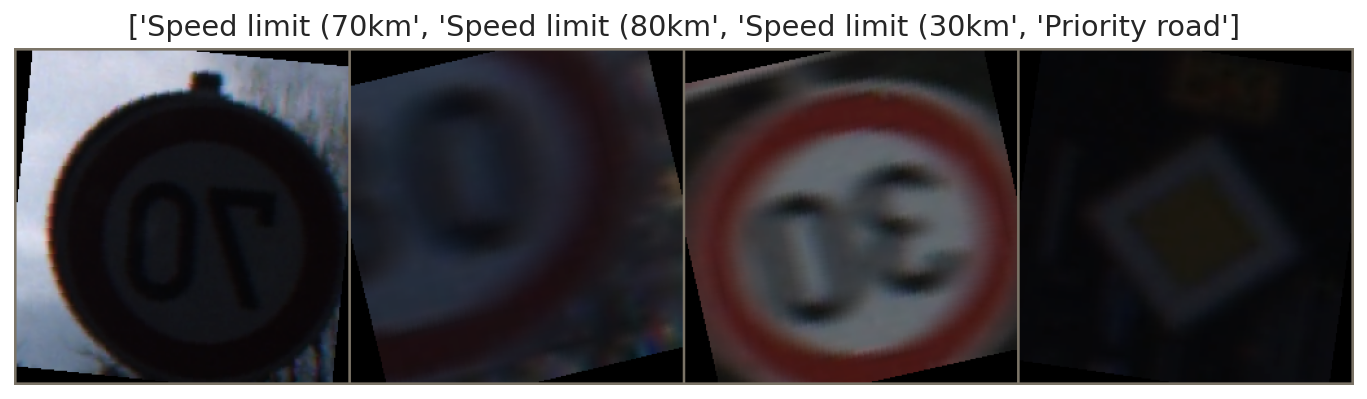

In [20]:
def imshow(inp, title=None):
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([mean_nums])
  std = np.array([std_nums])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.axis('off')

inputs, classes = next(iter(data_loaders['train']))
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Pre-Trained ResNet model:

In [0]:
def create_model(n_classes):
  model = models.resnet50(pretrained=True)

  n_features = model.fc.in_features
  model.fc = nn.Linear(n_features, n_classes)

  return model.to(device)

In [24]:
base_model = create_model(len(class_names))

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


Training:

In [0]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for inputs, labels in data_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    outputs = model(inputs)

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, labels)

    correct_predictions += torch.sum(preds == labels)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  scheduler.step()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)

      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, labels)

      correct_predictions += torch.sum(preds == labels)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [0]:
def train_model(model, data_loaders, dataset_sizes, device, n_epochs=10):
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
  scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
  loss_fn = nn.CrossEntropyLoss().to(device)

  history = defaultdict(list)
  best_accuracy = 0

  for epoch in range(n_epochs):

    print(f'Epoch {epoch + 1}/{n_epochs}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
      model,
      data_loaders['train'],    
      loss_fn, 
      optimizer, 
      device, 
      scheduler, 
      dataset_sizes['train']
    )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
      model,
      data_loaders['val'],
      loss_fn,
      device,
      dataset_sizes['val']
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
      torch.save(model.state_dict(), 'best_model_state.bin')
      best_accuracy = val_acc

  print(f'Best val accuracy: {best_accuracy}')
  
  model.load_state_dict(torch.load('best_model_state.bin'))

  return model, history

In [52]:
%%time

base_model, history = train_model(base_model, data_loaders, dataset_sizes, device)

Epoch 1/10
----------
Train loss 0.3015668571044735 accuracy 0.90483629291931
Val   loss 0.044486079619443626 accuracy 0.9841877072175466

Epoch 2/10
----------
Train loss 0.2852806158007223 accuracy 0.9112124206969107
Val   loss 0.0312641208932548 accuracy 0.9890334098444274

Epoch 3/10
----------
Train loss 0.2746600381207235 accuracy 0.914017916919055
Val   loss 0.03271441807197625 accuracy 0.986738077021168

Epoch 4/10
----------
Train loss 0.2523725024293619 accuracy 0.9207128510855357
Val   loss 0.06604963194704201 accuracy 0.9793420045906656

Epoch 5/10
----------
Train loss 0.2415530478114581 accuracy 0.9226575700577039
Val   loss 0.04530026363427243 accuracy 0.9880132619229788

Epoch 6/10
----------
Train loss 0.2472534245053471 accuracy 0.9221474798354958
Val   loss 0.028548608375494878 accuracy 0.9887783728640652

Epoch 7/10
----------
Train loss 0.234291562808165 accuracy 0.9244110051965441
Val   loss 0.02548324356992918 accuracy 0.9923488905891354

Epoch 8/10
----------
Tr

In [0]:
def plot_training_history(history):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

  ax1.plot(history['train_loss'], label='train loss')
  ax1.plot(history['val_loss'], label='validation loss')

  ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax1.set_ylim([-0.05, 1.05])
  ax1.legend()
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')

  ax2.plot(history['train_acc'], label='train accuracy')
  ax2.plot(history['val_acc'], label='validation accuracy')

  ax2.xaxis.set_major_locator(MaxNLocator(integer=True))
  ax2.set_ylim([-0.05, 1.05])
  ax2.legend()

  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')

  fig.suptitle('Training history')

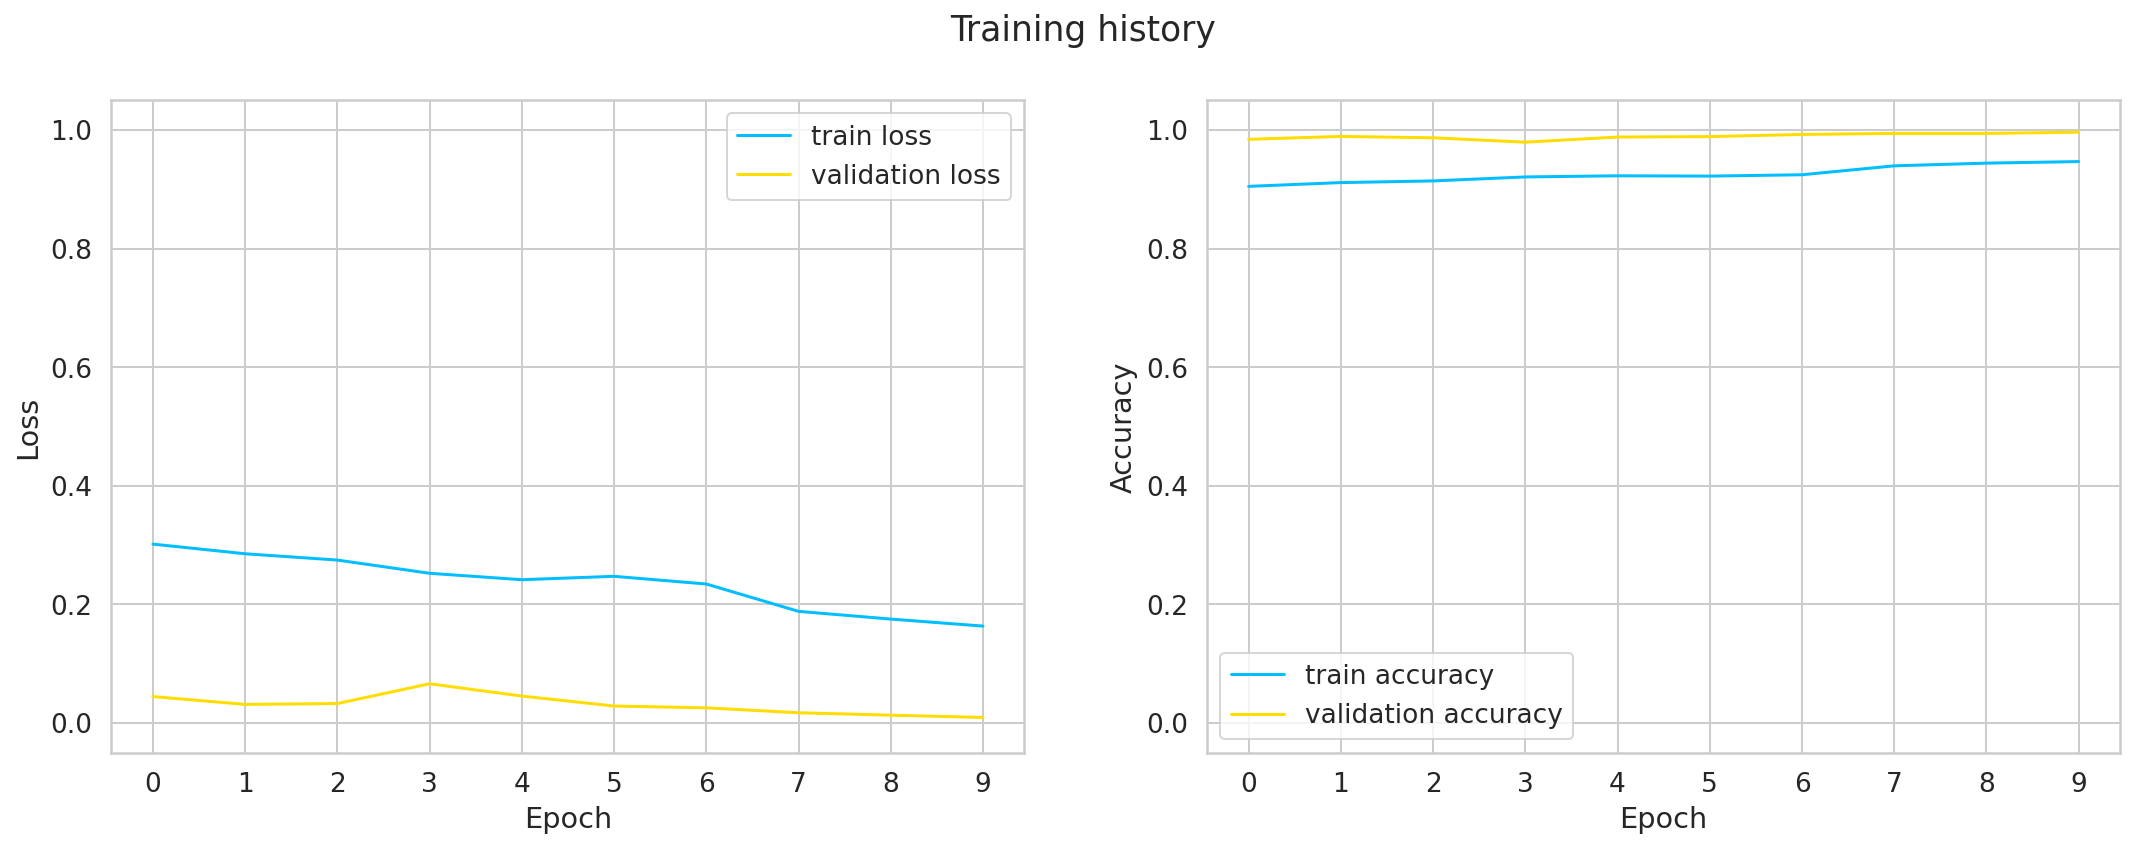

In [54]:
plot_training_history(history)

Evaluation:

In [0]:
def show_predictions(model, class_names, n_images=6):
  model = model.eval()
  images_handeled = 0
  plt.figure()

  with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      for j in range(inputs.shape[0]):
        images_handeled += 1
        ax = plt.subplot(2, n_images//2, images_handeled)
        ax.set_title(f'predicted: {class_names[preds[j]]}')
        imshow(inputs.cpu().data[j])
        ax.axis('off')

        if images_handeled == n_images:
          return

In [0]:
def get_predictions(model, data_loader):
  model = model.eval()
  predictions = []
  real_values = []
  with torch.no_grad():
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      predictions.extend(preds)
      real_values.extend(labels)
  predictions = torch.as_tensor(predictions).cpu()
  real_values = torch.as_tensor(real_values).cpu()
  return predictions, real_values

In [0]:
y_pred, y_test = get_predictions(base_model, data_loaders['test'])

In [58]:
print(classification_report(y_test, y_pred, target_names=class_names))

                               precision    recall  f1-score   support

                   Ahead only       1.00      1.00      1.00       120
                Beware of ice       1.00      1.00      1.00        45
            Bicycles crossing       1.00      1.00      1.00        27
                   Bumpy road       1.00      1.00      1.00        39
            Children crossing       1.00      1.00      1.00        54
         Dangerous curve left       1.00      1.00      1.00        21
        Dangerous curve right       1.00      1.00      1.00        36
                 Double curve       1.00      1.00      1.00        33
End no passing veh > 3.5 tons       1.00      1.00      1.00        24
            End of no passing       1.00      1.00      1.00        24
     End of speed limit (80km       1.00      1.00      1.00        42
   End speed + passing limits       1.00      1.00      1.00        24
              General caution       1.00      1.00      1.00       120
     

In [0]:
def show_confusion_matrix(confusion_matrix, class_names):

  cm = confusion_matrix.copy()

  cell_counts = cm.flatten()

  cm_row_norm = cm / cm.sum(axis=1)[:, np.newaxis]

  row_percentages = ["{0:.2f}".format(value) for value in cm_row_norm.flatten()]

  cell_labels = [f"{cnt}\n{per}" for cnt, per in zip(cell_counts, row_percentages)]
  cell_labels = np.asarray(cell_labels).reshape(cm.shape[0], cm.shape[1])

  df_cm = pd.DataFrame(cm_row_norm, index=class_names, columns=class_names)

  hmap = sns.heatmap(df_cm, annot=cell_labels, fmt="", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Sign')
  plt.xlabel('Predicted Sign');

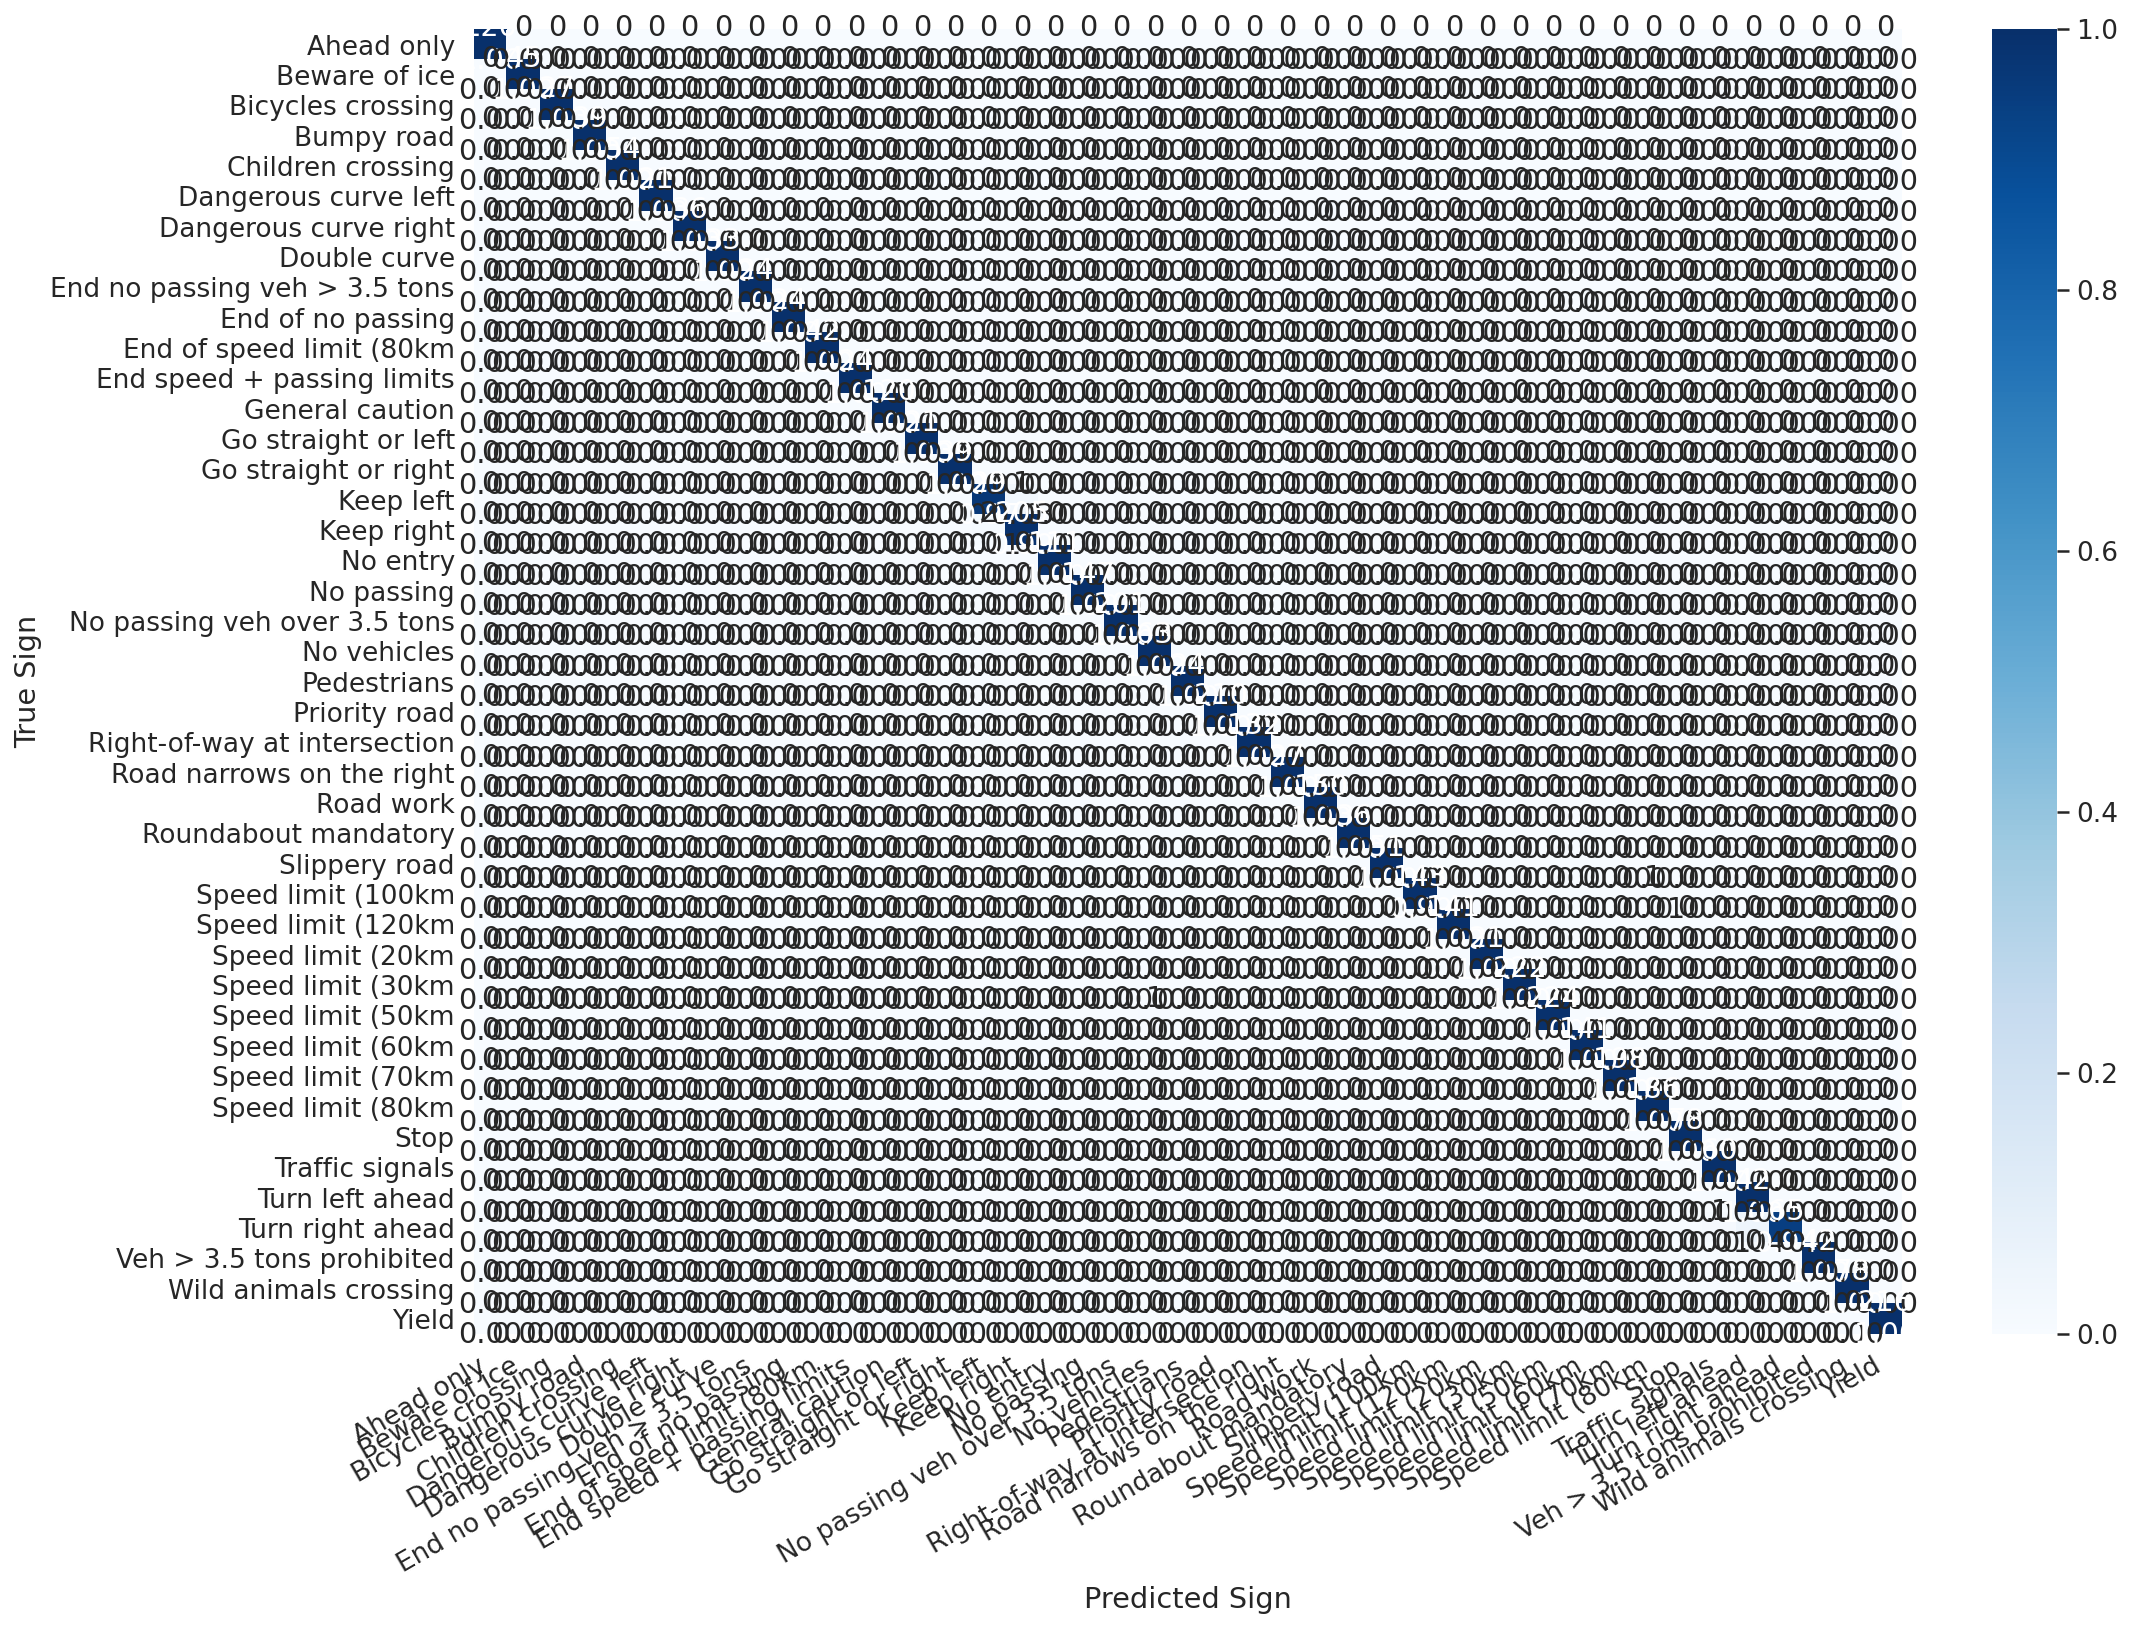

In [62]:
cm = confusion_matrix(y_test, y_pred)
show_confusion_matrix(cm, class_names)

Testing a new image:

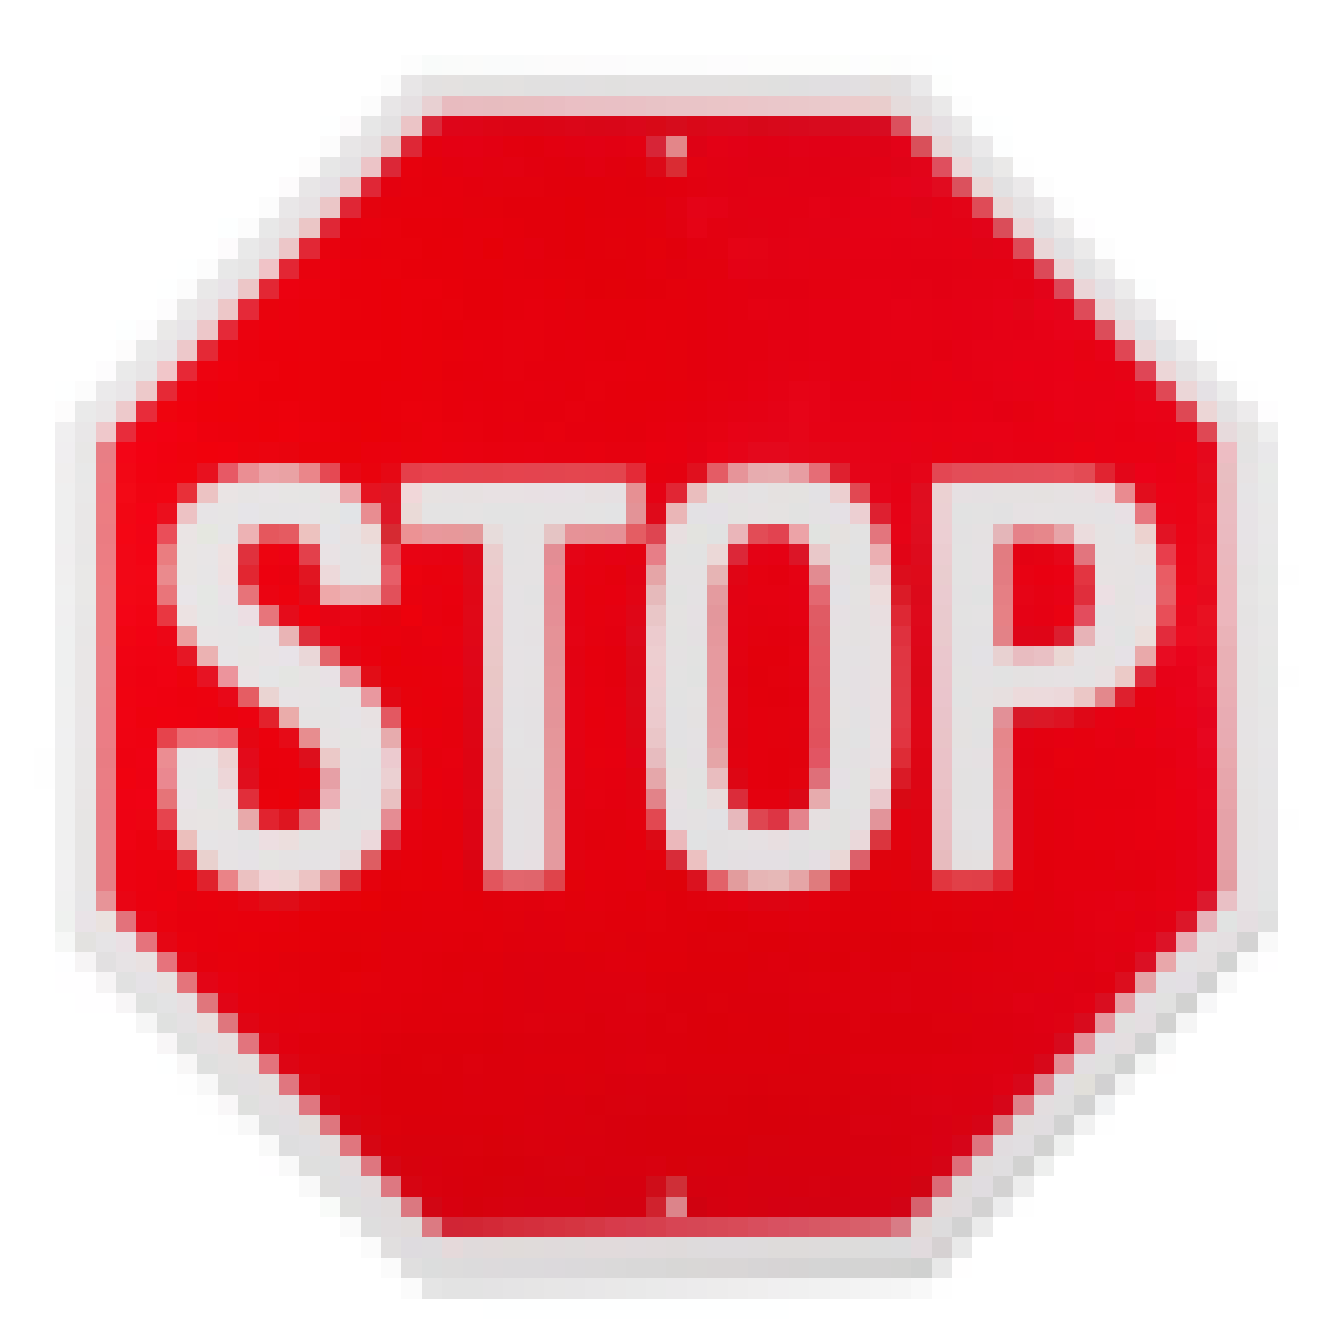

In [71]:
show_image('stop.jpeg')

In [0]:
def predict_proba(model, image_path):
  img = Image.open(image_path)
  img = img.convert('RGB')
  img = transforms['test'](img).unsqueeze(0)

  pred = model(img.to(device))
  pred = F.softmax(pred, dim=1)
  return pred.detach().cpu().numpy().flatten()

In [72]:
pred = predict_proba(base_model, 'stop.jpeg')
pred

array([2.42891020e-11, 2.52552250e-11, 2.29701137e-11, 9.37163097e-15,
       7.34854788e-10, 2.49137972e-12, 5.16769380e-15, 2.45731647e-11,
       7.33040798e-13, 2.22121410e-09, 3.02644910e-12, 1.65794827e-13,
       2.87837087e-09, 7.17338385e-12, 1.91606203e-10, 1.57974380e-08,
       3.34642825e-09, 1.74549405e-05, 1.07153366e-11, 7.34152797e-14,
       6.09438498e-12, 2.05977388e-11, 4.10320041e-07, 6.47395679e-11,
       9.15149553e-12, 4.14124450e-08, 1.49760246e-10, 4.48073267e-09,
       1.33236044e-11, 9.25677668e-08, 3.25549754e-10, 1.24683037e-08,
       3.50969982e-11, 4.21829997e-13, 1.47099541e-08, 3.74764629e-11,
       9.99981880e-01, 1.52106088e-11, 8.27212006e-08, 2.99025596e-11,
       1.80616557e-12, 1.20871195e-11, 7.29665128e-09], dtype=float32)

In [0]:
def show_prediction_confidence(prediction, class_names):
  pred_df = pd.DataFrame({
    'class_names': class_names,
    'values': prediction
  })
  sns.barplot(x='values', y='class_names', data=pred_df, orient='h')
  plt.xlim([0, 1]);

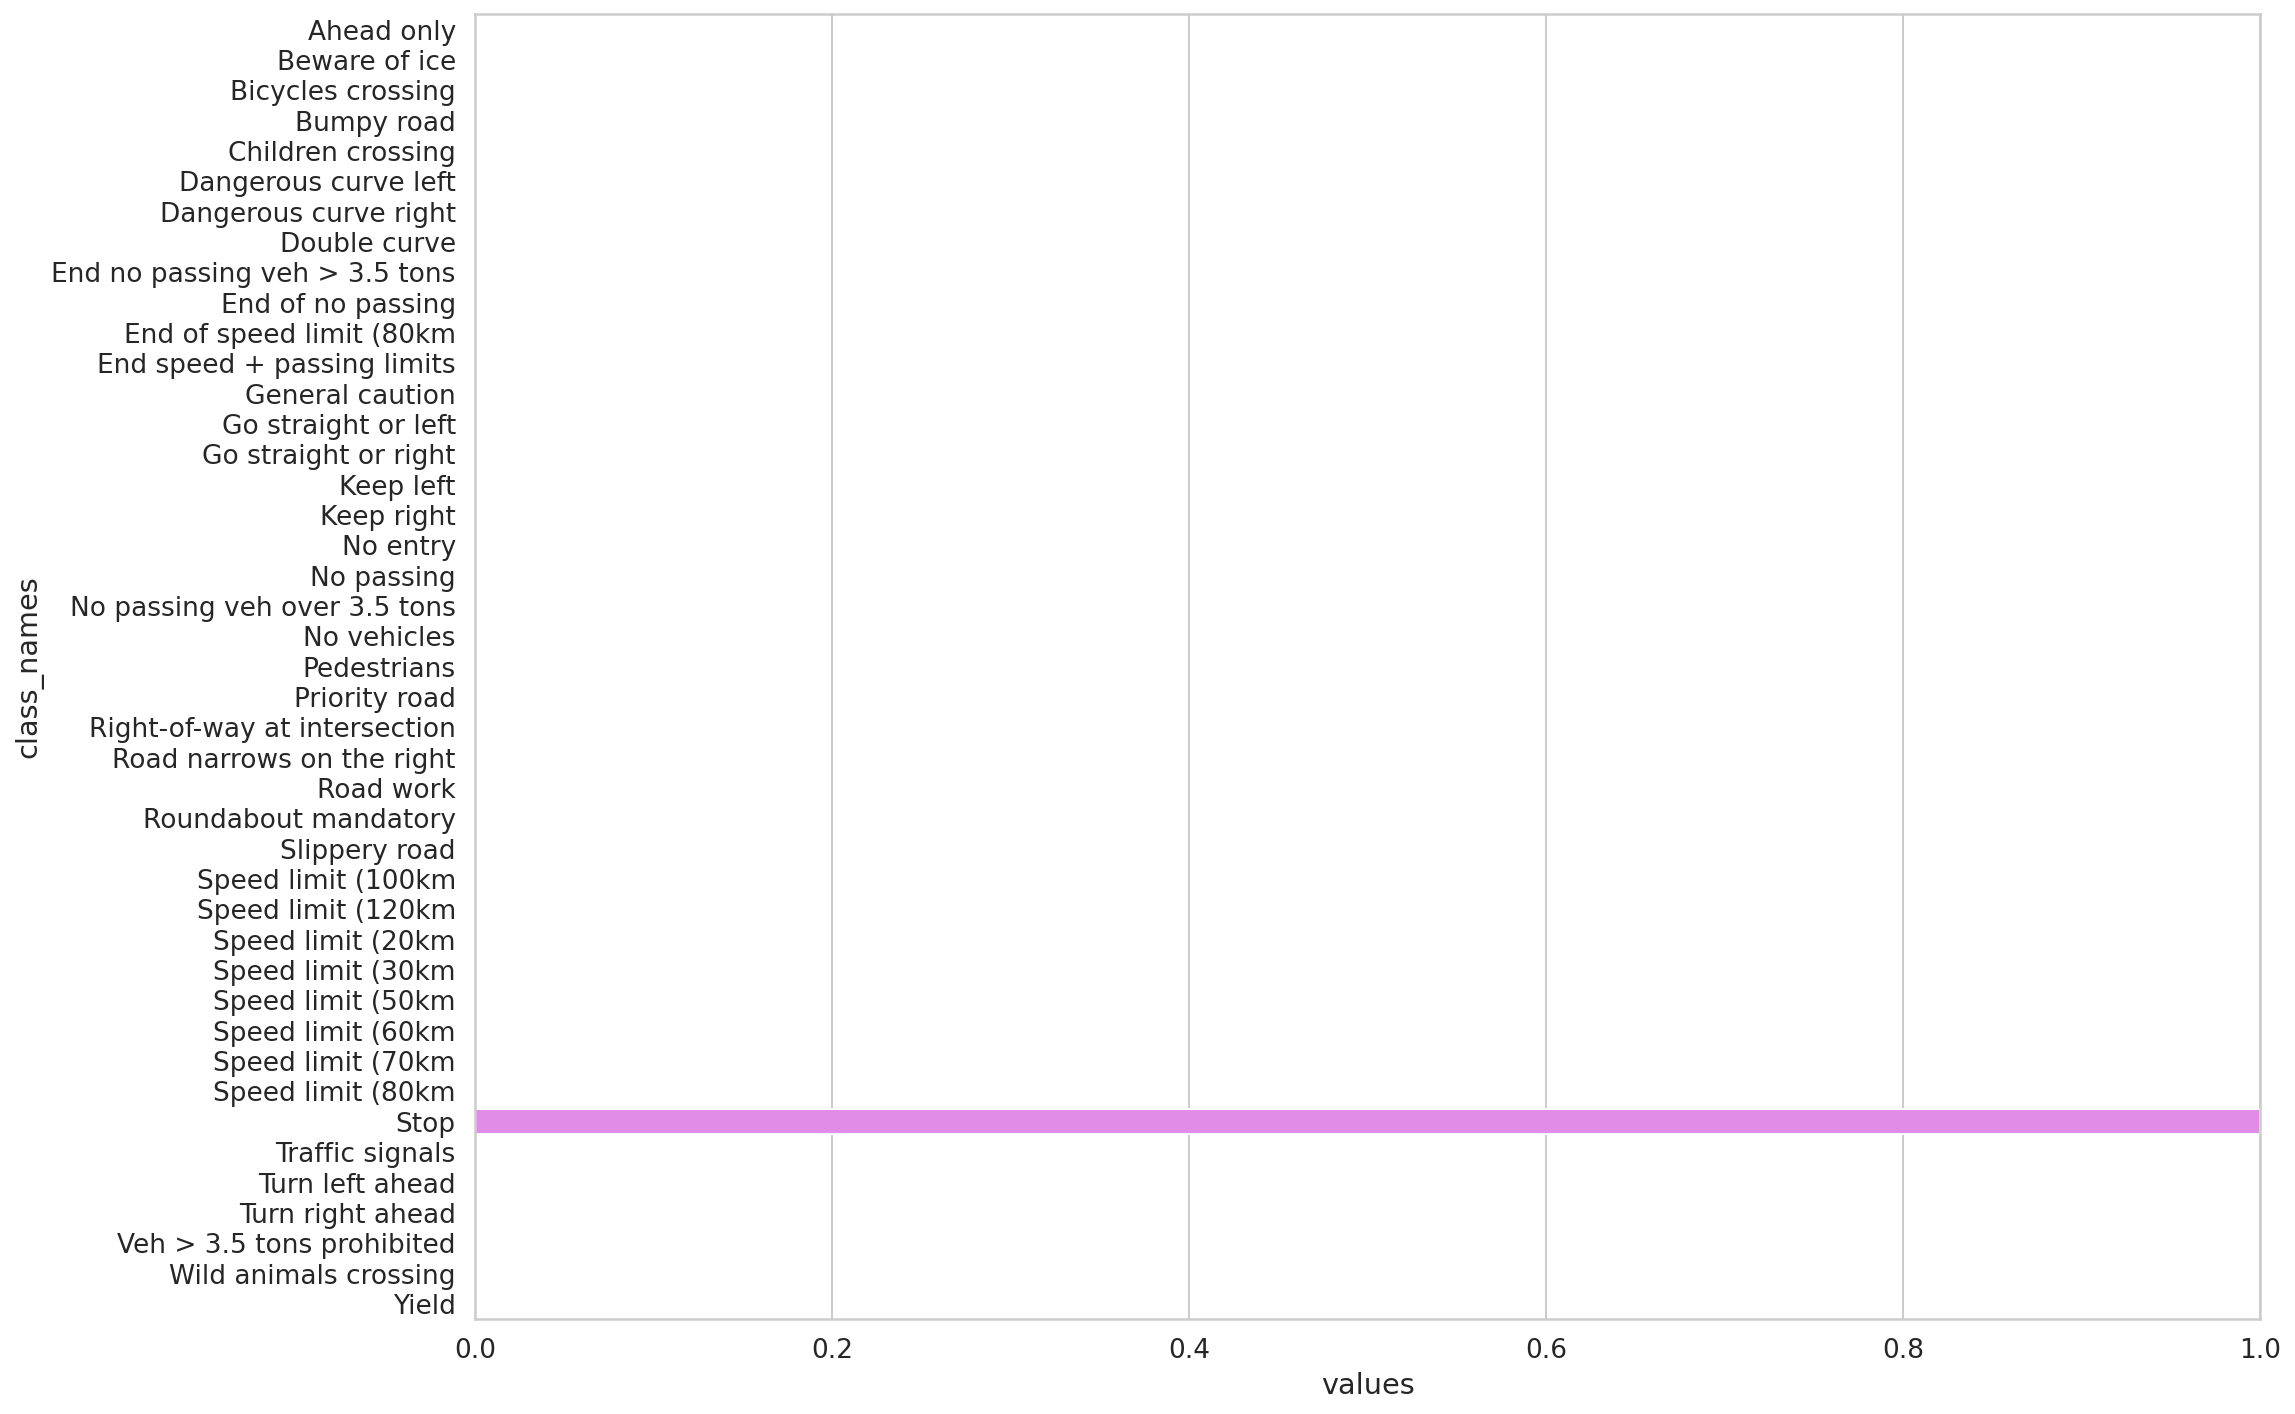

In [74]:
show_prediction_confidence(pred, class_names)

Reference:

https://towardsdatascience.com/transfer-learning-with-convolutional-neural-networks-in-pytorch-dd09190245ce

https://stackabuse.com/image-classification-with-transfer-learning-and-pytorch/